<a href="https://colab.research.google.com/github/ApoorvaHegde21/AQI_Prediction/blob/main/Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Data

In [2]:
# Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression

In [3]:
#Links Google colab to Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Read Data
data_2021 = pd.read_csv('/content/drive/MyDrive/Bagalkot_2021.csv')
data_2022 = pd.read_csv('/content/drive/MyDrive/Bagalkot_2022.csv')
data_2023 = pd.read_csv('/content/drive/MyDrive/Bagalkot_2023.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Pre-processing
- The three datasets for the years 2021,2022 and 2023
  are unified into a single dataset.
- The columns consisting of only null values and zeroes are dropped as they have no significant effect on the decision.
- Simple Imputation is performed to fill the null values with the mean values of the respective feature.

In [4]:
#Concatenate the datasets of different years into one merged dataset.
merged_data = pd.concat([data_2021,data_2022,data_2023],axis=0)

In [5]:
#Presents an overview of the data along with mean,max,std,inter quartile ranges.
merged_data.describe()

,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),Benzene (µg/m³),...,MP-Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s)
count,1073.000000,1075.000000,1074.000000,1073.000000,1074.000000,1074.000000,970.000000,1004.000000,967.000000,0.0,...,947.000000,1035.000000,836.000000,1037.000000,1037.000000,746.0,1095.0,1037.000000,1019.000000,0.0
mean,22.520856,43.109976,5.277450,8.776847,14.779518,5.692638,8.467661,0.582569,21.935674,NaN,...,0.525611,29.349989,65.334785,2.342010,151.906429,0.0,0.0,136.779610,817.126772,NaN
std,6.891620,10.229217,1.331384,2.322357,4.610086,2.095579,10.016703,0.137983,11.855016,NaN,...,0.109290,3.660191,10.725168,0.338649,72.977211,0.0,0.0,197.702693,55.809255,NaN
min,4.600000,7.180000,2.530000,0.160000,1.640000,0.010000,0.690000,0.120109,1.327000,NaN,...,0.020000,19.013913,14.190000,0.755313,17.480000,0.0,0.0,0.680000,701.330000,NaN
25%,18.350000,40.830000,4.070000,8.040000,11.990000,4.080000,4.212500,0.450000,14.190000,NaN,...,0.520000,27.722674,63.000000,2.210000,80.738542,0.0,0.0,0.700000,774.600417,NaN
50%,22.874271,43.250000,5.062500,9.450000,14.660000,6.910000,6.230000,0.603628,19.157436,NaN,...,0.520000,29.068438,63.000000,2.310000,147.320000,0.0,0.0,0.700000,823.712681,NaN
75%,25.857292,46.610000,6.640000,9.991528,19.860104,7.023872,9.115953,0.640725,28.635000,NaN,...,0.520625,31.694158,70.000000,2.390000,217.389479,0.0,0.0,281.370000,848.112257,NaN
max,55.160000,112.090000,11.089931,18.932222,23.081007,13.414826,94.918056,1.090000,68.310000,NaN,...,3.610000,37.693194,99.492500,3.520000,303.222361,0.0,0.0,827.070000,971.500000,NaN


In [6]:
#Drops tables that have only null values.
merged_data.dropna(axis=1, inplace=True, how='all')
merged_data = merged_data.loc[:,(merged_data!=0).any(axis=0)]
line_x = merged_data['Timestamp']
merged_data.describe()

,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),Toluene (µg/m³),Eth-Benzene (µg/m³),MP-Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),SR (W/mt2),BP (mmHg)
count,1073.000000,1075.000000,1074.000000,1073.000000,1074.000000,1074.000000,970.000000,1004.000000,967.000000,1076.000000,947.000000,947.000000,1035.000000,836.000000,1037.000000,1037.000000,746.0,1037.000000,1019.000000
mean,22.520856,43.109976,5.277450,8.776847,14.779518,5.692638,8.467661,0.582569,21.935674,0.900145,0.310493,0.525611,29.349989,65.334785,2.342010,151.906429,0.0,136.779610,817.126772
std,6.891620,10.229217,1.331384,2.322357,4.610086,2.095579,10.016703,0.137983,11.855016,0.377464,0.121871,0.109290,3.660191,10.725168,0.338649,72.977211,0.0,197.702693,55.809255
min,4.600000,7.180000,2.530000,0.160000,1.640000,0.010000,0.690000,0.120109,1.327000,0.000000,0.020000,0.020000,19.013913,14.190000,0.755313,17.480000,0.0,0.680000,701.330000
25%,18.350000,40.830000,4.070000,8.040000,11.990000,4.080000,4.212500,0.450000,14.190000,0.941832,0.280000,0.520000,27.722674,63.000000,2.210000,80.738542,0.0,0.700000,774.600417
50%,22.874271,43.250000,5.062500,9.450000,14.660000,6.910000,6.230000,0.603628,19.157436,0.950000,0.282882,0.520000,29.068438,63.000000,2.310000,147.320000,0.0,0.700000,823.712681
75%,25.857292,46.610000,6.640000,9.991528,19.860104,7.023872,9.115953,0.640725,28.635000,0.960000,0.290663,0.520625,31.694158,70.000000,2.390000,217.389479,0.0,281.370000,848.112257
max,55.160000,112.090000,11.089931,18.932222,23.081007,13.414826,94.918056,1.090000,68.310000,4.160000,3.540000,3.610000,37.693194,99.492500,3.520000,303.222361,0.0,827.070000,971.500000


In [7]:
#Imputation with a mean method is used to replace null values
my_imputer = SimpleImputer()
subset = merged_data.select_dtypes(include=['float64', 'int64']).columns
merged_data[subset] = pd.DataFrame(my_imputer.fit_transform(merged_data[subset]))


AQI Calculation is done in reference to the guidelines of Central Pollution Control Board and Calculating AQI Tutorial on Kaggle.

Target variable = AQI

In [8]:

## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0


## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0


## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0


## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

#Creation of Intermediate columns for sub-indexes.
merged_data['PM25'] = merged_data['PM2.5 (µg/m³)'].apply(get_PM25_subindex)
merged_data['PM10'] = merged_data['PM10 (µg/m³)'].apply(get_PM10_subindex)
merged_data['SO2'] = merged_data['SO2 (µg/m³)'].apply(get_SO2_subindex)
merged_data['NOx'] = merged_data['NOx (ppb)'].apply(get_NOx_subindex)
merged_data['NH3'] = merged_data['NH3 (µg/m³)'].apply(get_NH3_subindex)
merged_data['CO'] = merged_data['CO (mg/m³)'].apply(get_CO_subindex)
merged_data['O3'] = merged_data['Ozone (µg/m³)'].apply(get_O3_subindex)

#The AQI is assigned the maximum sub-index in the row.
merged_data['AQI'] = merged_data[['PM25','PM10','SO2','NOx','NH3','CO','O3']].max(axis=1).round()
#Drop intermediate columns and 'Timestamp'(as it has no influence on the prediction.)
merged_data.drop(['PM25','PM10','SO2','NOx','NH3','CO','O3','Timestamp'],axis=1,inplace=True)
merged_data.head()

,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),Toluene (µg/m³),Eth-Benzene (µg/m³),MP-Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),SR (W/mt2),BP (mmHg),AQI
0,12.23,36.00,3.32,1.38,2.65,1.23,5.97,0.582569,27.93,0.0,0.310493,0.525611,21.15,97.36,3.51,75.92,0.0,8.90,817.126772,36.0
1,13.65,43.25,3.59,2.11,2.85,1.87,5.36,0.582569,36.73,0.0,0.310493,0.525611,20.77,87.43,3.46,64.09,0.0,9.97,817.126772,43.0
2,12.57,37.72,3.55,2.09,2.90,2.02,4.82,0.582569,33.16,0.0,0.310493,0.525611,21.17,97.38,3.40,71.67,0.0,26.22,817.126772,38.0
3,9.91,24.54,3.51,2.18,3.00,1.97,4.08,0.582569,29.56,0.0,0.310493,0.525611,21.63,98.79,3.38,71.51,0.0,11.25,817.126772,30.0
4,9.63,21.62,3.10,2.09,2.43,1.76,5.31,0.582569,27.00,0.0,0.310493,0.525611,21.65,94.39,3.44,61.60,0.0,233.20,817.126772,29.0


The co-relation matrix reveals a high correlation between PM2.5 and PM10. One of them have to be dropped to get rid of this inter-dependency. Since PM10 already contains the concentration of PM2.5 molecules, PM2.5 is dropped.

In [9]:
#Correlation matrix is evaluated.
corr_matrix = merged_data.corr()
print(corr_matrix)
#PM2.5 is dropped.
merged_data.drop(columns = ['PM2.5 (µg/m³)'],inplace=True)


                     PM2.5 (µg/m³)  PM10 (µg/m³)  NO (µg/m³)  NO2 (µg/m³)  \
PM2.5 (µg/m³)             1.000000      0.820914    0.076888     0.108204   
PM10 (µg/m³)              0.820914      1.000000    0.029151    -0.063131   
NO (µg/m³)                0.076888      0.029151    1.000000     0.683512   
NO2 (µg/m³)               0.108204     -0.063131    0.683512     1.000000   
NOx (ppb)                 0.124347     -0.072165    0.674463     0.968715   
NH3 (µg/m³)               0.014844     -0.061291    0.925332     0.712495   
SO2 (µg/m³)               0.278660      0.371497   -0.132841    -0.387412   
CO (mg/m³)                0.258891      0.309476   -0.340268    -0.261357   
Ozone (µg/m³)             0.462638      0.529338   -0.309257    -0.411656   
Toluene (µg/m³)          -0.060712     -0.219018    0.475058     0.712248   
Eth-Benzene (µg/m³)      -0.067452     -0.101249    0.100355     0.131241   
MP-Xylene (µg/m³)        -0.026168     -0.026850    0.171170     0.056716   

In [10]:
#Uses the mutual_info technique to evaluate the dependency of the target variable on each variable.
X = merged_data.copy()
y = X.pop('AQI')

def mi_score(X,y):
  score = mutual_info_regression(X,y)
  score_col = pd.Series(score,index=X.columns,name='Score')
  score_col = score_col.sort_values(ascending=False)
  return score_col
scores = mi_score(X,y)
print(scores)

PM10 (µg/m³)           2.520895
Ozone (µg/m³)          0.828654
WS (m/s)               0.767710
BP (mmHg)              0.748208
AT (°C)                0.738057
SR (W/mt2)             0.725679
NH3 (µg/m³)            0.669224
SO2 (µg/m³)            0.621718
CO (mg/m³)             0.619098
NO (µg/m³)             0.594398
NOx (ppb)              0.573355
WD (deg)               0.566363
RH (%)                 0.547816
NO2 (µg/m³)            0.523476
Toluene (µg/m³)        0.389469
Eth-Benzene (µg/m³)    0.254421
MP-Xylene (µg/m³)      0.177017
RF (mm)                0.005634
Name: Score, dtype: float64


#Exploratory Data Analysis

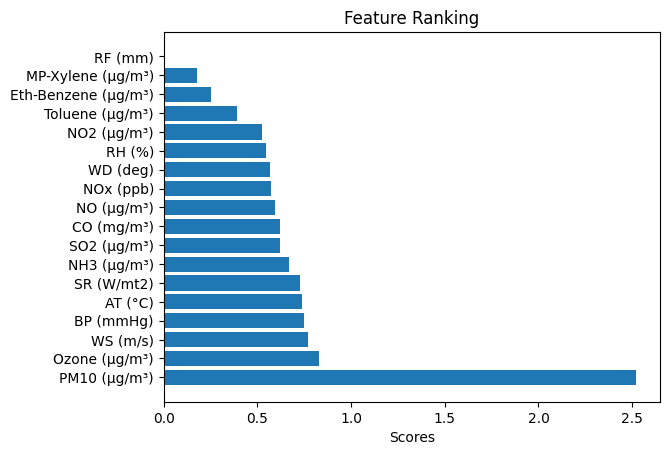

In [11]:
#Horizontal bar chart representing the dependency of the target variable on each feature in terms of the score generated.
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores, tick_label =ticks,)
plt.title('Feature Ranking')
plt.xlabel('Scores')
plt.show()

There exists a linear relationship between PM10 and the target variable. From the correlation matrix, it is quite clear that AQI is most dependent on PM10 feature.

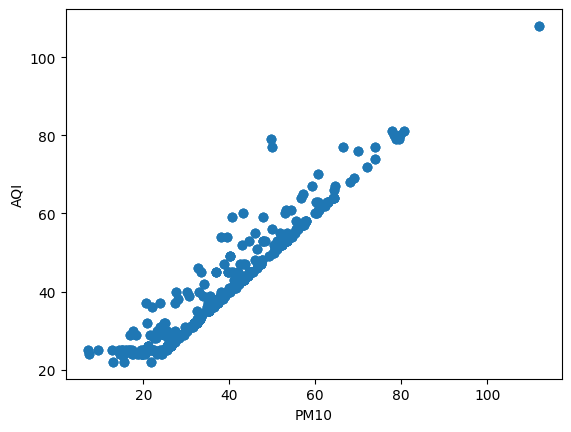

In [12]:
plt.scatter(merged_data['PM10 (µg/m³)'],y)
plt.xlabel('PM10')
plt.ylabel('AQI')
plt.show()

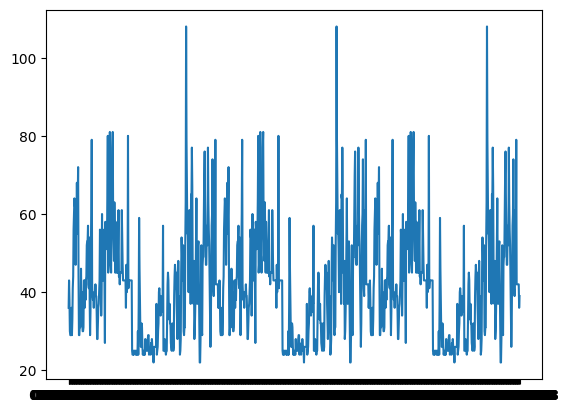

In [13]:
#AQI trend over the years. Presence of outliers can be seen.

line_y = merged_data['AQI']
plt.plot(line_x,line_y)
plt.show()

Since the data size is small and each feature other than PM10 has a very small significance in deciding AQI, including all the features in the clean dataset is a feasible and effective solution.

#Model Training

In [14]:
#Splits the data into training set and validation set.
train_X,val_X,train_y,val_y = train_test_split(X,y,random_state=1)
#Defines a Linear Regression model.
model = XGBRegressor()
#Training the model
model.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#Model Evaluation

In [15]:
#Predictions for validation data.
aqi_predictions = model.predict(val_X)
#Error Calculation.
error = mean_absolute_error(val_y,aqi_predictions)
print(error)


0.15547093161701286


The error calculated using the mean absolute error is approximately 0.15 for the AQI which has an approx mean of 42. AQI is mostly used in classifying air quality into brackets (Good,Average,Bad etc) with size 50. Therefore, this model is acceptable in most cases.